# BERTによる日本語ニュースタイトルの判別


# Classification of Japanese news-title by BERT

## 1. Import library （ライブラリの取得）

In [0]:
!pip install  sentencepiece
#!pip install tensorflow

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time
import seaborn as sns
import sys
from tqdm import tqdm_notebook

np.random.seed(10)

tf.__version__

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!test -d bert_repo || git clone https://github.com/tensorflow/models bert_repo

if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

max_seq_length = 50

Cloning into 'bert_repo'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 34076 (delta 4), reused 12 (delta 1), pack-reused 34060
Receiving objects: 100% (34076/34076), 512.36 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (21980/21980), done.
Checking out files: 100% (2493/2493), done.


In [0]:
%cd /content/bert_repo/official/nlp/bert
!ls

In [0]:
import tokenization
from tokenization import FullTokenizer

## 2. Load livedoor-news-data （ライブドアニュースデータの取得）


livedoor news corpus CC BY-ND 2.1 JP　　　https://www.rondhuit.com/download.html#ldcc

In [0]:
!ls

dev5.tsv	it-life-hack   livedoor-homme  peachy  sports-watch  train5.tsv
dokujo-tsushin	kaden-channel  movie-enter     smax    topic-news


In [0]:
train_df = pd.read_csv("train5.tsv", delimiter='\t', header=None, names=['label', 'title'])
dev_df = pd.read_csv("dev5.tsv", delimiter='\t', header=None, names=['label', 'title'])


In [0]:
train_df=train_df.loc[:, ['title','label']]
train_df=train_df.rename({'title':'sentence','label':'polarity'},axis='columns')
train_df.head() 

,sentence,polarity
0,"月額1,050円でSASディスクを搭載！クラウドプラン 「エクスライト（EX-LITE）」の...",0
1,例のあのメニューも！ニコニコ超会議のフードコートメニュー14種類紹介（前半）,0
2,山田孝之と小西真奈美の映画に撮影していない“あるモノ”が映り込んでいた,1
3,ガガを聴きながら毎朝歯磨き！ レディー・ガガ シンギングトゥースブラシ独占先行販売,0
4,斎藤佑樹はプロで通用するのか？,2


In [0]:
dev_df=dev_df.loc[:, ['title','label']]
dev_df=dev_df.rename({'title':'sentence','label':'polarity'},axis='columns')
dev_df.head(20) 

,sentence,polarity
0,ドコモのｓｐモードでまたトラブル発生！ 今度はつながらない【話題】,4
1,ダルビッシュ、今季だけで3つの魔球体得へ,2
2,本格的に仕事復帰、マリエが今一番会いたい人は“スギちゃん”,1
3,価格が安価で矯正を気づかれない！綺麗な歯並びになれる、歯列矯正の最前線,0
4,先輩・桑田、松井秀喜にズバリ「引退とかは考えなかった？」,2
5,【モテる家電】誰でもかっこよくなれる！ 男の正しい眉整え術,4
6,【オトナ女子のリアルな悩み】最長で半年…恋愛が長続きしない理由は？,3
7,虐待だ！の声多数、日テレで人気のワンコが声帯除去手術を受けていた事実に非難殺到【話題】,4
8,1枚で主食＋デザートに!? 宅配ピザ最前線「モッチリーノ」のお得なおいしさ,3
9,スマホで花咲く恋もある!? 合コンで使える本当の“モテテク”,3


In [0]:
# Create datasets (Only take up to max_seq_length words for memory)
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)
train_label = train_df['polarity'].tolist()

test_text = dev_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = dev_df['polarity'].tolist()

## 3. Tokenize texts and prepare data （テキストをトークン化、データを準備）


In [0]:
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1"

In [0]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer(bert_path, trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def convert_single_example(tokenizer, example, max_seq_length=max_seq_length):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids, dtype='int32'),
        np.array(input_masks, dtype='int32'),
        np.array(segment_ids, dtype='int32'),
        np.array(labels, dtype='int32').reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples
  


# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

#train_examples = train_examples[0:500]
#test_examples = test_examples[0:500]

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
print(train_input_ids.dtype)
print(train_input_ids[0])
print(type(train_input_ids))
print(np.shape(train_input_ids))

int32
[  101  4460  8399   122   117   121   126   121  2469  1939   156   138
   156  2022  1986  2008  1998  1980  4204  7612 10055  1998  2056  1989
  2024  2038  2056  2064  1890  1991  1998  2008  2056  1987  2023 10060
   142   161   118   149   146   157   142 10061  1891  1946  8618  2594
  1980   102]
<class 'numpy.ndarray'>
(3503, 50)


In [0]:
print(train_input_masks[0])
print(type(train_input_masks))
print(np.shape(train_input_masks))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
<class 'numpy.ndarray'>
(3503, 50)


In [0]:
print(train_segment_ids[0])
print(type(train_segment_ids))
print(np.shape(train_segment_ids))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
<class 'numpy.ndarray'>
(3503, 50)


##  4. Build BERT model (モデルの訓練)

In [0]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,name="segment_ids")

bert_layer = hub.KerasLayer(bert_path, trainable=False)

pooled_output = bert_layer([input_word_ids, input_mask, segment_ids])
x = tf.keras.layers.Dense(32, activation='relu')(pooled_output[0])
pred = tf.keras.layers.Dense(5, activation='softmax')(x) 

model=tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
t=time.time()

history = model.fit([train_input_ids, train_input_masks, train_segment_ids],
                    train_labels,
                    epochs=100,
                    batch_size=512,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
                    verbose=1)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Epoch 1/100
7/7 [==============================] - 15s 2s/step - loss: 1.6425 - accuracy: 0.1941 - val_loss: 1.5881 - val_accuracy: 0.2317
Epoch 2/100
7/7 [==============================] - 15s 2s/step - loss: 1.5717 - accuracy: 0.2992 - val_loss: 1.5389 - val_accuracy: 0.3265
Epoch 3/100
7/7 [==============================] - 15s 2s/step - loss: 1.5168 - accuracy: 0.4416 - val_loss: 1.4821 - val_accuracy: 0.5068
Epoch 4/100
7/7 [==============================] - 15s 2s/step - loss: 1.4635 - accuracy: 0.4679 - val_loss: 1.4321 - val_accuracy: 0.5034
Epoch 5/100
7/7 [==============================] - 15s 2s/step - loss: 1.4111 - accuracy: 0.5470 - val_loss: 1.3790 - val_accuracy: 0.5263
Epoch 6/100
7/7 [==============================] - 15s 2s/step - loss: 1.3613 - accuracy: 0.5658 - val_loss: 1.3338 - val_accuracy: 0.5354
Epoch 7/100
7/7 [==============================] - 15s 2s/step - loss: 1.3097 - accuracy: 0.5678 - val_loss: 1.2741 - val_accuracy: 0.5457
Epoch 8/100
7/7 [==========

##  5. Evaluate the model (モデルの評価)

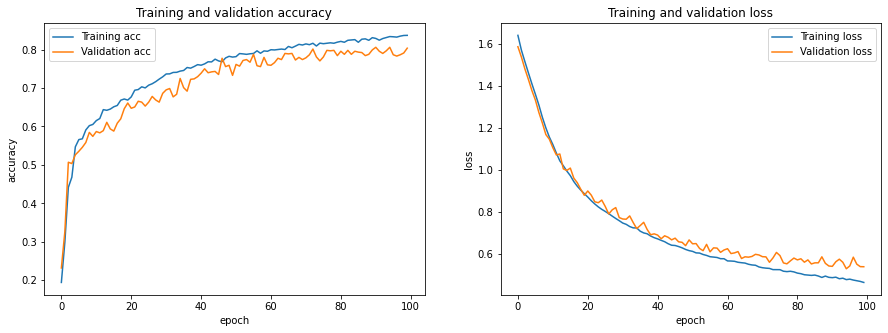

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

In [0]:
model.save('LL5-Bert_20200417.h5')

# predictions before we clear and reload model
pre_save_preds = model.predict([test_input_ids[0:100], 
                                test_input_masks[0:100], 
                                test_segment_ids[0:100]]
                              ) 

In [0]:
pre_save_preds[0]

array([0.01228216, 0.09334585, 0.00542319, 0.00662073, 0.8823281 ],
      dtype=float32)

In [0]:
np.argmax(pre_save_preds[0])

4

In [0]:
pre=np.argmax(pre_save_preds[0])

if pre==0:
  pred='it-life-hack'
  
elif pre==1:
  pred='movie-enter'
  
elif pre==2:
  pred='sports-watch'
  
elif pre==3:
  pred='dokujo-tsushin'
  
elif pre==4:
  pred='kaden-channel'
    
pred

'kaden-channel'

In [0]:
pre=np.argmax(pre_save_preds[1])

if pre==0:
  pred='it-life-hack'
  
elif pre==1:
  pred='movie-enter'
  
elif pre==2:
  pred='sports-watch'
  
elif pre==3:
  pred='dokujo-tsushin'
  
elif pre==4:
  pred='kaden-channel'
    
pred

'movie-enter'

In [0]:
pre=np.argmax(pre_save_preds[2])

if pre==0:
  pred='it-life-hack'
  
elif pre==1:
  pred='movie-enter'
  
elif pre==2:
  pred='sports-watch'
  
elif pre==3:
  pred='dokujo-tsushin'
  
elif pre==4:
  pred='kaden-channel'
    
pred

'sports-watch'

In [0]:
pre=np.argmax(pre_save_preds[3])

if pre==0:
  pred='it-life-hack'
  
elif pre==1:
  pred='movie-enter'
  
elif pre==2:
  pred='sports-watch'
  
elif pre==3:
  pred='dokujo-tsushin'
  
elif pre==4:
  pred='kaden-channel'
    
pred

'it-life-hack'

In [0]:
pre=np.argmax(pre_save_preds[4])

if pre==0:
  pred='it-life-hack'
  
elif pre==1:
  pred='movie-enter'
  
elif pre==2:
  pred='sports-watch'
  
elif pre==3:
  pred='dokujo-tsushin'
  
elif pre==4:
  pred='kaden-channel'
    
pred

'sports-watch'

In [0]:
test_label[0:5]

[4, 2, 1, 0, 2]

In [0]:
category_dirs =  ['it-life-hack', 'movie-enter', 'sports-watch', 'dokujo-tsushin', 'kaden-channel']

In [0]:
!nvidia-smi

Fri Apr 17 04:00:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    24W /  75W |   4337MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  